In [1]:
from __future__ import print_function,division 
from pykalman import KalmanFilter
from numpy import linalg
import numpy as np
import pandas as pd
from scipy import poly1d

from collections import defaultdict
import itertools

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

import statsmodels.tools.tools as stt

/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read the data 

In [2]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

coupon = 4.5

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

full_dates = data.index
ret_dates = data.index[1:]

moneyness = coupon/100 - rates

tenor=10
swp_dur = pd.read_csv('tsy5y+10y.csv',index_col=0, header=0, skiprows=0)['10 year note Current Modified Duration']
swp_dur=pd.DataFrame(np.array(swp_dur),columns=['swap_duration'],index=swp_dur.index)
swp_dur.index=pd.to_datetime(swp_dur.index, format='%d-%b-%y')
one_day_return = pd.read_excel('1day-return_USD10Y.xlsx',index_col=0, header=0) 
one_day_return.index=pd.to_datetime(one_day_return.index, format='%Y%m%d')

In [3]:
test_data = pd.concat([data, one_day_return], join='inner',axis=1).iloc[1:].copy()
test_data['return'] = ret
test_data['ratio'] = test_data['data'] / test_data['return']
TBA_return = ret
instru_return = test_data['data']

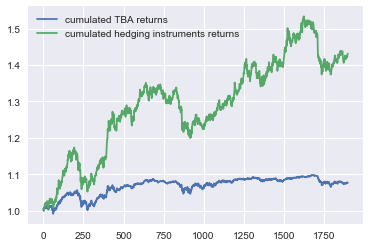

In [7]:
t_cum_return = np.cumprod(TBA_return + 1)
i_cum_return = np.cumprod(instru_return.values + 1)
plt.plot(t_cum_return,label='cumulated TBA returns')
plt.plot(i_cum_return, label='cumulated hedging instruments returns')
plt.legend()
plt.show()

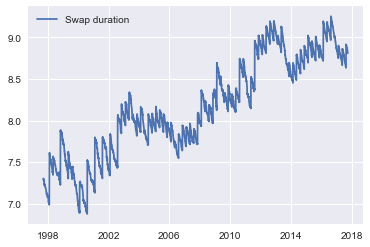

In [9]:
plt.plot(swp_dur,label='Swap duration')
plt.legend()
plt.show()

# Rolling windows


In [10]:
window_20 = 20
D_20_wInt = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_wInt.append(- result.params[-1])
window_120 = 120
D_120_wInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_wInt.append(- result.params[-1])

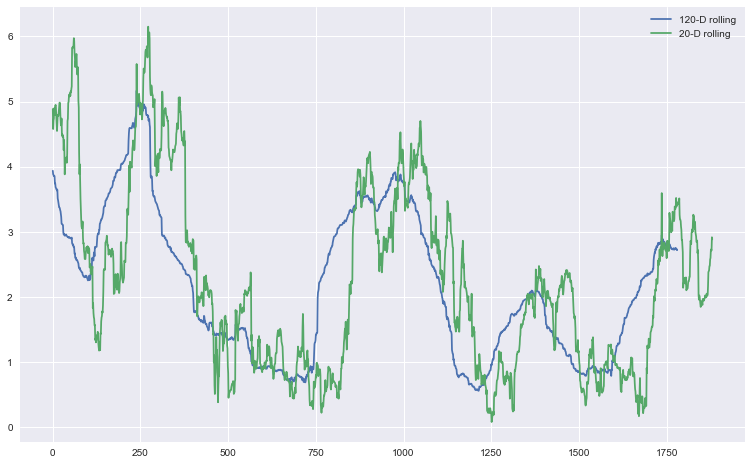

In [38]:
plt.figure(figsize=(13,8))
plt.plot(D_120_wInt,label='120-D rolling')
plt.plot(D_20_wInt, label='20-D rolling')
plt.legend()
plt.show()

# Simple Kalman Filter using rolling Duration as observations


Here we assume we observed the D_20 duration, then we assume the intrinsic duration is the state and follow the simple rule:

\begin{align}
D^{rolling}_t &= D^{in}_t + v_t\\
D^{in}_{t+1} & = D^{in}_t + u_t
\end{align}

Both $v\sim N(0,0.1)$ and $u\sim N(0,0)$

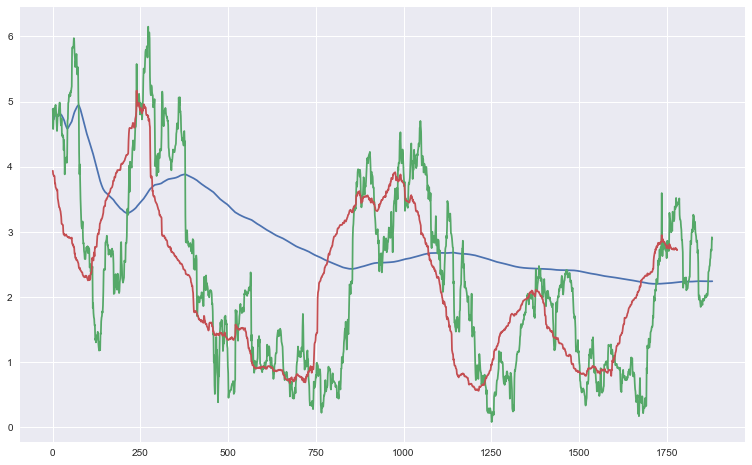

In [37]:
# Write Kalman Filter w/o package
plt.figure(figsize=(13,8))
filtered = [D_20_wInt[0]]
R = 1
p = 1
for i in D_20_wInt[1:]:
    K = p /(p + R)
    filtered.append(filtered[-1] + K * (i - filtered[-1]))
    p = (1 - K) * p

plt.plot(filtered)
plt.plot(D_20_wInt)
plt.plot(D_120_wInt)

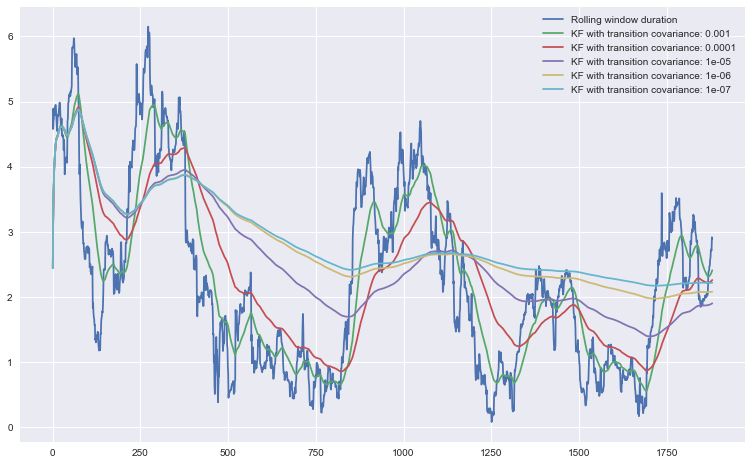

In [17]:
tran_cov = [1e-3,1e-4,1e-5,1e-6,1e-7]
plt.figure(figsize=(13,8))
plt.plot(D_20_wInt,label = 'Rolling window duration')
for cov in tran_cov:
    kf = KalmanFilter(initial_state_mean=0,initial_state_covariance=1,
        observation_matrices = 1,
                      transition_matrices = 1,
                      transition_covariance = cov,
                     observation_covariance = 1)

    state_mean_beta,_ = kf.filter(D_20_wInt)
    plt.plot(state_mean_beta, label = 'KF with transition covariance: '+str(cov))
plt.legend()
plt.show()

# A little bit complex case using two set of state variables

\begin{align}
D^{roll}_t &= \alpha D^{in}_t + \beta M_t + \epsilon_t\\
D^{in}_t &= D^{in}_{t-1} + v_t\\
M_t &= m_t + u_t\\
\end{align}

In [27]:
obs_cov = [10,100,1000,1e4,1e5]
tran_mat = np.matrix([[1,0],[0,0]])
m  = (moneyness[21:])

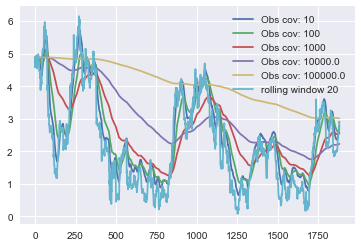

In [28]:
for ob in obs_cov:
    kFF = KalmanFilter(initial_state_mean= [D_20_wInt[0],0],
                      initial_state_covariance = np.matrix([[0.01,0],[0,0]]),
                      observation_matrices = np.matrix([1,-20]),
                      observation_covariance = ob,
                      transition_matrices = tran_mat,
                      transition_covariance = np.matrix([[0.1,0],[0,0.001]]),
                      transition_offsets = np.vstack((np.zeros_like(m),m)).T)

    smb,_= kFF.filter(D_20_wInt)
    plt.plot(smb[:,0],label='Obs cov: '+str(ob))
    
plt.plot(D_20_wInt,label='rolling window 20')
plt.legend()
plt.show()

## Some questions about hedging


In [32]:
test_ret = ret[20:]
test_instru = instru_return[20:].values
sp = pd.concat([data, swp_dur], join='inner',axis=1).iloc[1:].copy()['swap_duration'].values
test_sp = sp[20:]

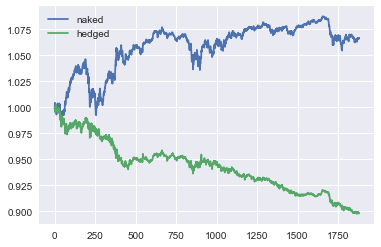

In [35]:
les_ratios = np.divide(D_20_wInt, test_sp)

hedged_ret2 = test_ret - np.multiply(les_ratios, test_instru)
cum_naked = np.cumprod(1 + test_ret)
cum_hedged2 = np.cumprod(1 + hedged_ret2)
plt.plot(cum_naked , label = 'naked')
plt.plot(cum_hedged2, label = 'hedged')
plt.legend()
plt.show()

In [36]:
test_sp

array([ 8.17092,  8.17855,  8.17759, ...,  8.91125,  8.9141 ,  8.91659])